In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import statsmodels.formula.api as smf

In [ ]:
rdp = pd.read_excel('data.xlsx', index_col=0)

rdp.head()

,GDPPOT_20230726,GDPC1_20230727
observation_date,,
1950-01-01,2218.566586,2186.365
1950-04-01,2248.161822,2253.045
1950-07-01,2277.049682,2340.112
1950-10-01,2306.715167,2384.920
1951-01-01,2336.504742,2417.311


<Axes: xlabel='observation_date', ylabel='GDPC1_20230727'>

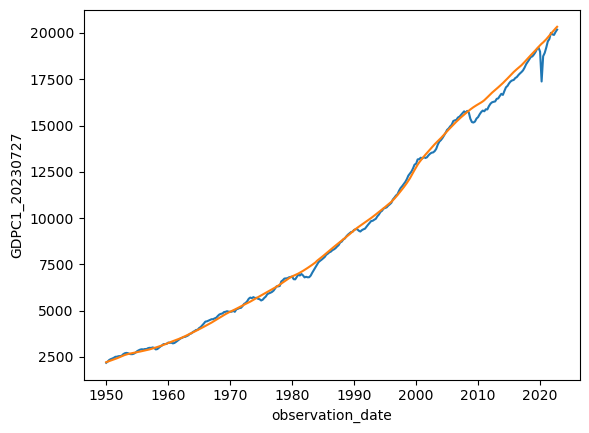

In [ ]:
rdp = rdp.dropna()

sns.lineplot(data=rdp, x='observation_date', y='GDPC1_20230727')
sns.lineplot(data=rdp, x='observation_date', y='GDPPOT_20230726')

In [ ]:
nrou = pd.read_csv('NROU.csv', index_col=0)

nrou.head()

,NROU
DATE,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


In [ ]:
unrate = pd.read_csv('UNRATE.csv', index_col=0)

unrate.head()

,UNRATE
DATE,
1948-01-01,3.7333333333333333
1948-04-01,3.6666666666666667
1948-07-01,3.7666666666666667
1948-10-01,3.8333333333333333
1949-01-01,4.6666666666666667


In [ ]:
unemployment = pd.merge(left=unrate, right=nrou, left_index=True, right_index=True)

unemployment.head()

,UNRATE,NROU
DATE,,
1949-01-01,4.6666666666666667,5.255053
1949-04-01,5.8666666666666667,5.261516
1949-07-01,6.7000000000000000,5.268013
1949-10-01,6.9666666666666667,5.274564
1950-01-01,6.4000000000000000,5.281182


<Axes: xlabel='DATE', ylabel='UNRATE'>

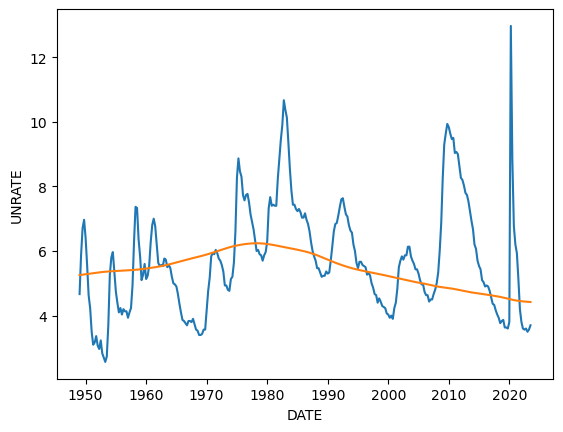

In [ ]:
unemployment = unemployment[:-1]
unemployment['UNRATE'] = unemployment['UNRATE'].astype(float)
unemployment.index = pd.to_datetime(unemployment.index)

sns.lineplot(data=unemployment, x='DATE', y='UNRATE')
sns.lineplot(data=unemployment, x='DATE', y='NROU')

In [ ]:
data = pd.merge(left=unemployment, right=rdp, left_index=True, right_index=True)

data.head()

,UNRATE,NROU,GDPPOT_20230726,GDPC1_20230727
1950-01-01,6.400000,5.281182,2218.566586,2186.365
1950-04-01,5.566667,5.287866,2248.161822,2253.045
1950-07-01,4.633333,5.294604,2277.049682,2340.112
1950-10-01,4.233333,5.301367,2306.715167,2384.920
1951-01-01,3.500000,5.308113,2336.504742,2417.311


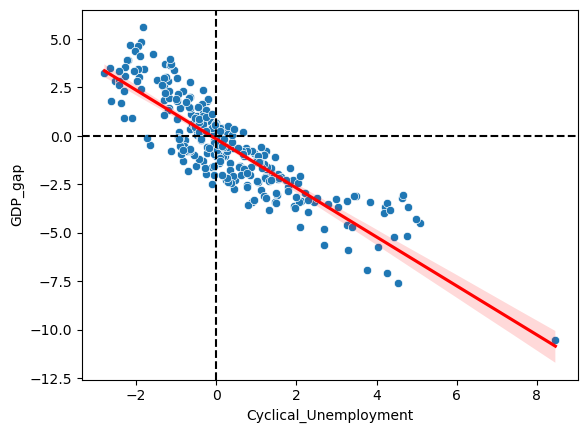

In [ ]:
data['GDP_gap'] = (data['GDPC1_20230727'] - data['GDPPOT_20230726']) / data['GDPPOT_20230726'] * 100

data['Cyclical_Unemployment'] = data['UNRATE'] - data['NROU']

sns.scatterplot(data=data, x='Cyclical_Unemployment', y='GDP_gap')
sns.regplot(data=data, x='Cyclical_Unemployment', y='GDP_gap', scatter=False, color='r')
plt.axhline(y=0, color='k', linestyle='--')
plt.axvline(x=0, color='k', linestyle='--')
plt.show()

In [ ]:
model = sm.OLS(data['GDP_gap'], sm.add_constant(data['Cyclical_Unemployment'])).fit()

print(model.summary2())

                   Results: Ordinary least squares
Model:                 OLS               Adj. R-squared:      0.764   
Dependent Variable:    GDP_gap           AIC:                 928.1463
Date:                  2023-12-16 01:34  BIC:                 935.4998
No. Observations:      292               Log-Likelihood:      -462.07 
Df Model:              1                 F-statistic:         940.5   
Df Residuals:          290               Prob (F-statistic):  5.19e-93
R-squared:             0.764             Scale:               1.3964  
----------------------------------------------------------------------
                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                 -0.1596   0.0704  -2.2674 0.0241 -0.2982 -0.0211
Cyclical_Unemployment -1.2609   0.0411 -30.6671 0.0000 -1.3419 -1.1800
----------------------------------------------------------------------
Omnibus:                 1

Метод Ходрика-Прескотта (HP-фильтр)

In [ ]:
data_last = data[data.index.year > 2008].copy()
data_last.index.name = 'date'

In [ ]:
model = sm.OLS(data_last['GDP_gap'], sm.add_constant(data_last['Cyclical_Unemployment'])).fit()

print(model.summary2())

                   Results: Ordinary least squares
Model:                 OLS               Adj. R-squared:      0.792   
Dependent Variable:    GDP_gap           AIC:                 134.1512
Date:                  2023-12-16 01:34  BIC:                 138.2019
No. Observations:      56                Log-Likelihood:      -65.076 
Df Model:              1                 F-statistic:         210.4   
Df Residuals:          54                Prob (F-statistic):  2.86e-20
R-squared:             0.796             Scale:               0.62041 
----------------------------------------------------------------------
                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                 -1.3647   0.1319 -10.3426 0.0000 -1.6292 -1.1002
Cyclical_Unemployment -0.6896   0.0475 -14.5042 0.0000 -0.7849 -0.5943
----------------------------------------------------------------------
Omnibus:               21.

In [ ]:
from statsmodels.stats.diagnostic import linear_reset

model = smf.ols('GDP_gap ~ Cyclical_Unemployment', data=data).fit()

p_values = []
for i in range(2, 6):
    p_values.append(linear_reset(model, use_f=True, power=i).pvalue)

plt.plot(range(2, 6), p_values)
plt.xlabel('степень полинома')
plt.xticks(range(2, 6))
plt.ylabel('p-value')
plt.grid()
plt.show()

In [ ]:
model = smf.ols('GDP_gap ~ Cyclical_Unemployment + np.square(Cyclical_Unemployment)', data_last).fit()

print(model.summary2())

                         Results: Ordinary least squares
Model:                    OLS                   Adj. R-squared:          0.826   
Dependent Variable:       GDP_gap               AIC:                     125.2411
Date:                     2023-12-16 01:34      BIC:                     131.3171
No. Observations:         56                    Log-Likelihood:          -59.621 
Df Model:                 2                     F-statistic:             131.1   
Df Residuals:             53                    Prob (F-statistic):      3.00e-21
R-squared:                0.832                 Scale:                   0.52022 
---------------------------------------------------------------------------------
                                  Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------
Intercept                        -1.3779   0.1209 -11.3981 0.0000 -1.6204 -1.1354
Cyclical_Unemployment            -0.4116 

In [ ]:
data_pred = data[data.index.year < 2008].copy()

model = sm.OLS(data_pred['GDP_gap'], sm.add_constant(data_pred['Cyclical_Unemployment'])).fit()

print(model.summary2())

                   Results: Ordinary least squares
Model:                 OLS               Adj. R-squared:      0.818   
Dependent Variable:    GDP_gap           AIC:                 662.6620
Date:                  2023-12-16 01:34  BIC:                 669.5554
No. Observations:      232               Log-Likelihood:      -329.33 
Df Model:              1                 F-statistic:         1037.   
Df Residuals:          230               Prob (F-statistic):  3.60e-87
R-squared:             0.818             Scale:               1.0099  
----------------------------------------------------------------------
                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                 -0.1140   0.0660  -1.7278 0.0854 -0.2440  0.0160
Cyclical_Unemployment -1.5805   0.0491 -32.1972 0.0000 -1.6772 -1.4838
----------------------------------------------------------------------
Omnibus:                6.